In [2]:
from modelDesign import *

2024-08-29 19:25:12.463429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 19:25:12.475971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 19:25:12.479483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 19:25:12.499144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 19:25:13.309712: W tensorflow/compiler/tf2

In [3]:
df = pd.read_csv('data/player_stats.csv')
df = df.sort_values(by=['player_id', 'season', 'week'])

## Data Preparation

In [7]:
sequence_length = 3
tscv = TimeSeriesSplit(n_splits=5)

df = featureEngineering(df)

qb_df_features, qb_df_target, rb_df_features, rb_df_target, wr_df_features, wr_df_target, te_df_features, te_df_target = cleanData(df)

X_qb, y_qb = create_sequences(qb_df_features.values, qb_df_target.values, sequence_length)
X_rb, y_rb = create_sequences(rb_df_features.values, rb_df_target.values, sequence_length)
X_wr, y_wr = create_sequences(wr_df_features.values, wr_df_target.values, sequence_length)
X_te, y_te = create_sequences(te_df_features.values, te_df_target.values, sequence_length)

/home/calder/Documents/ff2024/dataPreparation.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[numeric_cols] = df[numeric_cols].applymap(lambda x: np.nan if np.isinf(x) else x)
/home/calder/Documents/ff2024/dataPreparation.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(


In [8]:
#list all types of data in df
df.dtypes

player_id               object
player_name             object
player_display_name     object
position                object
position_group          object
                        ...   
moving_avg_fp_3w       float64
fp_diff_wow            float64
fp_pct_change_2w       float64
fp_momentum_3w         float64
fp_acceleration        float64
Length: 65, dtype: object

In [9]:
X_qb.shape

df

player_id   player_name    player_display_name  \
player_id  season                                                           
00-0000003 1999   0       00-0000003           NaN  Abdul-Karim al-Jabbar   
                  1       00-0000003           NaN  Abdul-Karim al-Jabbar   
                  2       00-0000003           NaN  Abdul-Karim al-Jabbar   
                  3       00-0000003           NaN  Abdul-Karim al-Jabbar   
                  4       00-0000003           NaN  Abdul-Karim al-Jabbar   
...                              ...           ...                    ...   
00-0039165 2023   128868  00-0039165  Z.Charbonnet        Zach Charbonnet   
                  128869  00-0039165  Z.Charbonnet        Zach Charbonnet   
                  128870  00-0039165  Z.Charbonnet        Zach Charbonnet   
                  128871  00-0039165  Z.Charbonnet        Zach Charbonnet   
                  128872  00-0039165  Z.Charbonnet        Zach Charbonnet   

                         position position_group  \
player_id  season                                  
00-0000003 1999   0            RB             RB   
                  1            RB             RB   
                  2            RB             RB   
                  3            RB             RB   
                  4            RB             RB   
...                           ...            ...   
00-0039165 2023   128868       RB             RB   
                  128869       RB             RB   
                  128870       RB             RB   
                  128871       RB             RB   
                  128872       RB             RB   

                                                               headshot_url  \
player_id  season                                                             
00-0000003 1999   0                                                     NaN   
                  1                                                     NaN   
                  2                                                     NaN   
                  3                                                     NaN   
                  4                                                     NaN   
...                                                                     ...   
00-0039165 2023   128868  https://static.www.nfl.com/image/private/f_aut...   
                  128869  https://static.www.nfl.com/image/private/f_aut...   
                  128870  https://static.www.nfl.com/image/private/f_aut...   
                  128871  https://static.www.nfl.com/image/private/f_aut...   
                  128872  https://static.www.nfl.com/image/private/f_aut...   

                         recent_team  season  week season_type  ...  \
player_id  season                                               ...   
00-0000003 1999   0              MIA    1999     1         REG  ...   
                  1              MIA    1999     2         REG  ...   
                  2              MIA    1999     4         REG  ...   
                  3              CLE    1999     7         REG  ...   
                  4              CLE    1999     8         REG  ...   
...                              ...     ...   ...         ...  ...   
00-0039165 2023   128868         SEA    2023    14         REG  ...   
                  128869         SEA    2023    15         REG  ...   
                  128870         SEA    2023    16         REG  ...   
                  128871         SEA    2023    17         REG  ...   
                  128872         SEA    2023    18         REG  ...   

                         rolling_passing_yards  rolling_fantasy_points  \
player_id  season                                                        
00-0000003 1999   0                        0.0                0.000000   
                  1                        0.0               12.700000   
                  2                        0.0                8.900000   
                  3       

In [10]:
datasets = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for X, y, key in [(X_qb, y_qb, 'qb'), 
                  (X_rb, y_rb, 'rb'), 
                  (X_wr, y_wr, 'wr'), 
                  (X_te, y_te, 'te')]:
    for i, (X_train, X_test, y_train, y_test) in enumerate(process_data(X, y, tscv)):
        datasets[key].append({
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        })
        

# Training/Hyperparameter tuning

In [ ]:
import keras_tuner as kt

# Instantiate the tuner
tuner = kt.RandomSearch(
    buildModelGRU,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuning',
    project_name='gru_tuning'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(x_val, y_val), epochs=50)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

I0000 00:00:1724970785.275281  332618 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724970785.343563  332618 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724970785.346357  332618 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724970785.349300  332618 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

ValueError: Cannot convert '<keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7a092874f370>' to a shape.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=50,                # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best metric value
)

# Training

### GRU

In [ ]:
# run the model on the normalized datasets
rnn_models_gru = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, datasets in datasets.items():
    for i, dataset in enumerate(datasets):
        print(f"Training RNN model for {key} - split {i + 1}...")
        
        # Get the input shape
        input_shape = dataset['X_train'].shape[1:]
        
        # Create the RNN model
        model = buildModelGRU(input_shape,
                                units=512
                                )
        
        # Train the model
        model.fit(
            dataset['X_train'],
            dataset['y_train'],
            epochs=150,
            batch_size=32,
            validation_data=(dataset['X_test'], dataset['y_test']),
            verbose=1,
            callbacks=[early_stopping]
        )
        
        # Store the model
        rnn_models_gru[key].append(model)

Training RNN model for qb - split 1...


I0000 00:00:1724968153.106032  324125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724968153.192230  324125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724968153.194314  324125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724968153.197365  324125 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


2024-08-29 17:49:15.504497: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 181.1431 - mae: 11.2297 - val_loss: 197.3822 - val_mae: 11.4894
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 163.4272 - mae: 10.6475 - val_loss: 173.0025 - val_mae: 10.6321
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 123.9740 - mae: 9.0060 - val_loss: 141.1855 - val_mae: 9.2538
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 83.7116 - mae: 7.2186 - val_loss: 101.9131 - val_mae: 7.8340
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62.3418 - mae: 6.1742 - val_loss: 91.6439 - val_mae: 7.4598
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 52.0456 - mae: 5.7216 - val_loss: 86.4689 - val_mae: 7.3974
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 49.0523 - mae: 5.5493 - val_loss: 88.2716 - val_mae: 7.4934
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 49.7840 - mae: 5.6244 - val_loss: 94.7804 - val_mae: 7.7445
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - los

2024-08-29 17:50:28.462832: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 893987976 exceeds 10% of free system memory.
2024-08-29 17:50:29.243296: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 893987976 exceeds 10% of free system memory.


Epoch 1/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 84.0391 - mae: 6.8404 - val_loss: 41.0235 - val_mae: 4.9112
Epoch 2/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 42.4024 - mae: 4.8768 - val_loss: 41.6904 - val_mae: 4.9451
Epoch 3/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 40.1407 - mae: 4.6918 - val_loss: 41.3636 - val_mae: 4.8714
Epoch 4/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 39.4506 - mae: 4.6314 - val_loss: 41.7739 - val_mae: 4.8982
Epoch 5/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 38.0016 - mae: 4.5227 - val_loss: 42.4491 - val_mae: 4.9834
Training RNN model for rb - split 4...


2024-08-29 17:50:49.105145: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1191903048 exceeds 10% of free system memory.
2024-08-29 17:50:50.179951: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1191903048 exceeds 10% of free system memory.


Epoch 1/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 79.9807 - mae: 6.6467 - val_loss: 44.5137 - val_mae: 5.1642
Epoch 2/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 42.4810 - mae: 4.8334 - val_loss: 43.9237 - val_mae: 5.0182
Epoch 3/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 40.5454 - mae: 4.7018 - val_loss: 44.2202 - val_mae: 5.0663
Epoch 4/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 37.6944 - mae: 4.5489 - val_loss: 44.8508 - val_mae: 5.1232
Training RNN model for rb - split 5...


2024-08-29 17:51:12.611610: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1489818120 exceeds 10% of free system memory.


Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 70.8190 - mae: 6.2258 - val_loss: 48.9341 - val_mae: 5.4183
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 42.8718 - mae: 4.8373 - val_loss: 48.1351 - val_mae: 5.3102
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 40.0570 - mae: 4.6472 - val_loss: 49.9197 - val_mae: 5.5094
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 38.6049 - mae: 4.5714 - val_loss: 50.3379 - val_mae: 5.5342
Training RNN model for wr - split 1...
Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 138.9602 - mae: 9.3756 - val_loss: 67.7253 - val_mae: 5.6471
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 70.6803 - mae: 6.1185 - val_loss: 48.1162 - val_mae: 5.1831
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 54.9385 - mae: 5.6915 - val_loss: 48.9281 - val_mae: 5.3889
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 53.5913 - mae: 5.6345 - val_loss: 49.1935 - val_mae: 5.4394


# Model tuning and cross-validation

# Testing

### GRU

In [1]:
# Test the model on the test data
rnn_predictions_gru = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models_gru.items():
    for i, model in enumerate(models):
        dataset = datasets[key][i]
        print(f"Testing RNN model for {key} - split {i + 1}...")
        
        # Make predictions
        y_pred = model.predict(dataset['X_test'])
        
        # Store the predictions
        rnn_predictions_gru[key].append(y_pred)

# Output the predictions
for key, predictions in rnn_predictions_gru.items():
    print(f"Predictions for {key}:")
    for i, prediction in enumerate(predictions):
        print(f"  Split {i + 1}:")
        print(f"    Shape: {prediction.shape}")
        

NameError: name 'rnn_models_gru' is not defined

In [ ]:
type(datasets)

list

# Performance evaluation

#### RMSE
#### MAE

# Prediction

/tmp/ipykernel_324125/624265048.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pl.legend()


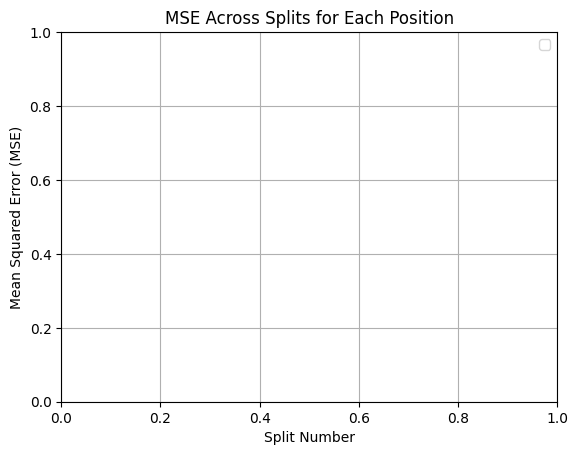

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 800x600 with 0 Axes>

In [ ]:
def plot_predictions(y_true, y_pred, key, split):
    pl.figure(figsize=(10, 6))
    pl.scatter(y_true, y_pred, alpha=0.3)
    pl.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    pl.xlabel('Actual')
    pl.ylabel('Predicted')
    pl.title(f'Predictions vs. Actuals for {key.upper()} - Split {split + 1}')
    pl.grid(True)
    pl.show()


def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R² Score: {r2}')
    return mse, mae, r2

for key, predictions in rnn_predictions_gru.items():
    for i, prediction in enumerate(predictions):
        dataset = datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        print(f"Evaluating RNN model for {key} - split {i + 1}...")
        
        # Plot Predictions vs. Actuals
        plot_predictions(y_true, y_pred, key, i)

        # Calculate and print evaluation metrics
        mse, mae, r2 = evaluate_predictions(y_true, y_pred)

        # Optionally, store the metrics for later comparison

evaluation_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, predictions in rnn_predictions_gru.items():
    for i, prediction in enumerate(predictions):
        dataset = datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        mse, mae, r2 = evaluate_predictions(y_true, y_pred)
        evaluation_results[key].append((mse, mae, r2))
        
pl.xlabel('Split Number')
pl.ylabel('Mean Squared Error (MSE)')
pl.title('MSE Across Splits for Each Position')
pl.legend()
pl.grid(True)
pl.show()

# Initialize the evaluation results dictionary
evaluation_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

# Evaluate predictions and store the MSE, MAE, R² score
for key, predictions in rnn_predictions_gru.items():
    for i, prediction in enumerate(predictions):
        dataset = datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        mse, mae, r2 = evaluate_predictions(y_true, y_pred)
        evaluation_results[key].append(mse)  # Storing only MSE for heatmap

# Convert the evaluation results into a DataFrame for heatmap plotting
import pandas as pd

# Convert evaluation results to a DataFrame
heatmap_data = pd.DataFrame(evaluation_results)

# Plot the heatmap
pl.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, annot=True, cmap='coolwarm', fmt=".3f", cbar=True)

pl.xlabel('Split Number')
pl.ylabel('Position')
pl.title('MSE Heatmap Across Splits and Positions')
pl.show()


In [ ]:
def compute_permutation_importance(model, X_test, y_test, n_repeats=5):
    baseline_mse = mean_squared_error(y_test, model.predict(X_test))
    importances = np.zeros(X_test.shape[1])

    for i in range(X_test.shape[1]):
        shuffled_mses = []
        for _ in range(n_repeats):
            X_test_permuted = X_test.copy()
            np.random.shuffle(X_test_permuted[:, i])
            shuffled_mses.append(mean_squared_error(y_test, model.predict(X_test_permuted)))
        
        importances[i] = np.mean(shuffled_mses) - baseline_mse

    return importances

# Compute permutation feature importance for each model and each split
feature_importance_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models_gru.items():
    for i, model in enumerate(models):
        dataset = normalized_datasets[key][i]
        X_test = dataset['X_test']
        y_test = dataset['y_test']

        print(f"Computing feature importance for {key} - split {i + 1}...")
        importances = compute_permutation_importance(model, X_test, y_test)
        feature_importance_results[key].append(importances)

# Convert feature importance results to DataFrame
import pandas as pd

# Assuming all splits have the same number of features, create a DataFrame
feature_names = [f'Feature_{j}' for j in range(X_test.shape[1])]
importance_df = pd.DataFrame(np.mean(np.array([np.array(importance).T for importance in feature_importance_results[key]]), axis=0),
                             columns=feature_names)

# Plot the feature importances as a heatmap
pl.figure(figsize=(12, 8))
sns.heatmap(importance_df, annot=True, cmap='viridis', fmt=".3f", cbar=True)

pl.xlabel('Features')
pl.ylabel('Position')
pl.title('Permutation Feature Importance Heatmap')
pl.show()

Computing feature importance for qb - split 1...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Computing feature importance for qb - split 2...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
61/61 

ValueError: Shape of passed values is (3, 1), indices imply (3, 3)